# Next-Frame Video Prediction with Convolutional LSTMs

**Author:** [Amogh Joshi](https://github.com/amogh7joshi)<br>
**Date created:** 2021/06/02<br>
**Last modified:** 2021/06/05<br>
**Description:** How to build and train a convolutional LSTM model for next-frame video prediction.

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [ ]:
%%capture
!pip install imageio

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [ ]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819216384/819200096 [==============================] - 8s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 818.


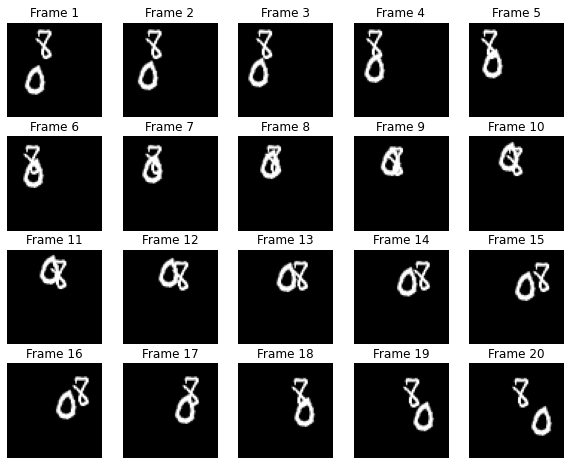

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(config={"hyper": "parameter"})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nouamanetazi (use `wandb login --relogin` to force relogin)


In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, WandbCallback()],
)

Epoch 1/20
180/180 [==============================] - ETA: 0s - loss: 0.1426

2022-02-13 20:41:53.410735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/Relu_1' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/mul_5', 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/mul_2' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/add_5', 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/convolution_7' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/add_6', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/mul_2' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/add_5', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/clip_by_value' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/mul_3', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/clip_by_va

180/180 [==============================] - 132s 732ms/step - loss: 0.1426 - val_loss: 0.3393 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 133s 736ms/step - loss: 0.1070 - val_loss: 0.2899 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 131s 730ms/step - loss: 0.0473 - val_loss: 0.2707 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 133s 739ms/step - loss: 0.0317 - val_loss: 0.2118 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 132s 731ms/step - loss: 0.0292 - val_loss: 0.1803 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 133s 737ms/step - loss: 0.0281 - val_loss: 0.1553 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 132s 735ms/step - loss: 0.0274 - val_loss: 0.1472 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 132s 735ms/step - loss: 0.0270 - val_loss: 0.1390 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 133s 739ms/step - los

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

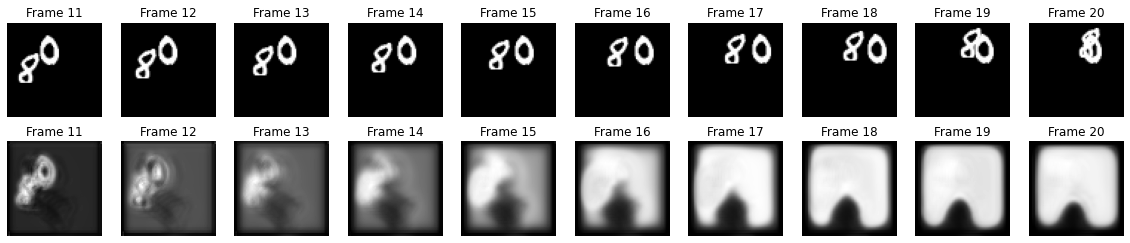

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


In [ ]:
model.save("saved_models")

2022-02-13 21:42:41.774353: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/assets


## Gradio

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/projects/draft_conv_lstm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/projects/draft_conv_lstm


In [4]:
# load model
from tensorflow import keras
model = keras.models.load_model('saved_models')

In [6]:
%%capture
!pip install gradio moviepy scikit-image

In [8]:
rgb2gray?

In [47]:
import os
import yaml

import imageio, cv2
from moviepy.editor import *
from skimage.transform import resize
from skimage import img_as_ubyte

from skimage.color import rgb2gray

import gradio as gr

def inference(driving,
              split_pred = 0.4, # predict 0.6% of video
              predict_one = False,
              output_name = 'output.mp4',
              output_path = 'asset/output',
              cpu = False,
              ):

    # driving
    reader = imageio.get_reader(driving)
    fps = reader.get_meta_data()['fps']
    driving_video = []
    try:
        for im in reader:
            driving_video.append(im)
    except RuntimeError:
        pass
    reader.close()
    driving_video = [rgb2gray(resize(frame, (64, 64)))[..., np.newaxis] for frame in driving_video]
    
    example = np.array(driving_video)
    print(example.shape)
    # Pick the first/last ten frames from the example.
    start_pred_id = int(split_pred * example.shape[0]) # prediction starts from frame start_pred_id
    frames = example[:start_pred_id, ...] 
    original_frames = example[start_pred_id:, ...]
    new_predictions = np.zeros(shape=(example.shape[0] - start_pred_id, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(example.shape[0] - start_pred_id):
        # Extract the model's prediction and post-process it.
        if predict_one:
            frames = example[: start_pred_id + i + 1, ...]
        else:
            frames = np.concatenate((example[: start_pred_id+1 , ...], new_predictions[:i, ...]), axis=0)
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.

    def postprocess(frame_set, save_file):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            print(f'{output_path}/{save_file}')    
            imageio.mimsave(f'{output_path}/{save_file}', current_frames, fps=fps)

    # save video
    os.makedirs(output_path, exist_ok=True)
    postprocess(original_frames, "original.mp4")
    postprocess(new_predictions, output_name)
    return f'{output_path}/{output_name}', f'{output_path}/original.mp4'

# inference("asset/driving/example.mp4")

In [48]:
import gradio as gr
import os
samples = []

example_driving = os.listdir('asset/driving')
for video in example_driving:
    samples.append([f'asset/driving/{video}', 0.5, False])

iface = gr.Interface(
    inference, # main function
    inputs = [ 
        gr.inputs.Video(label='Video', type='mp4'), # driving video
        gr.inputs.Slider(minimum=.1, maximum=.9, default=.5, step=.001, label="prediction start"),
        gr.inputs.Checkbox(label="predict one frame only", default=False), 
        
    ],
    outputs = [
        gr.outputs.Video(label='result'), # generated video
        gr.outputs.Video(label='ground truth') # generated video
    ], 
    
    title = 'Face Vid2Vid Demo',
    description = "This app is an unofficial demo web app of the face video2video. The codes are heavily based on this repo, created by zhanglonghao1992",
    
    examples = samples,
)

In [49]:
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://18118.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(10, 64, 64, 1)
asset/output/original_frames.mp4
asset/output/output.mp4
(20, 64, 64, 1)
asset/output/original_frames.mp4
asset/output/output.mp4
(20, 64, 64, 1)
asset/output/original_frames.mp4
asset/output/output.mp4
(20, 64, 64, 1)
asset/output/original_frames.mp4
asset/output/output.mp4
(20, 64, 64, 1)
asset/output/original_frames.mp4
asset/output/output.mp4
(20, 64, 64, 1)
asset/output/original_frames.mp4
asset/output/output.mp4
Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7fb67b67f590>,
 'http://127.0.0.1:7863/',
 'https://18118.gradio.app')